# About this notebook
The aim of this notebook is to compare three approaches to calculate VaR metrics. 
* Equally weighted quantile
* Expoentially weighted quantile
* EWMA (and equally weighted quantile)

by YL

In [14]:
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.optimize as sciop
import ptvsd
import yahoo_finance_pynterface as yhoo

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get equity historical data
Take log changes as the structure level-scaling model

In [15]:
# simulation
tickers = [r'^IXIC', r'^GSPC', r'AAPL']
period = ['2004-01-01', '2020-11-25']
kw_sims = {}
for ticker in tickers:
    df_t = yhoo.Get.Prices(ticker, period=period)
    df_t.index = df_t.index.date
    kw_sims[ticker] = df_t['Adj Close'][~df_t['Adj Close'].isnull()]
    
df_sims = pd.concat(kw_sims, axis=1).dropna(axis=0)
df_sims = np.log(df_sims).diff()
df_sims.tail(10)

,^IXIC,^GSPC,AAPL
2020-11-11,0.019929,0.007623,0.029901
2020-11-12,-0.006541,-0.010029,-0.002346
2020-11-13,0.010171,0.013519,0.000419
2020-11-16,0.007985,0.011581,0.008683
2020-11-17,-0.002081,-0.004803,-0.007593
2020-11-18,-0.008248,-0.011631,-0.011457
2020-11-19,0.008699,0.003939,0.005155
2020-11-20,-0.004187,-0.006816,-0.011018
2020-11-23,0.002162,0.005620,-0.030194
2020-11-24,0.013058,0.016032,0.011528


# Portfolio

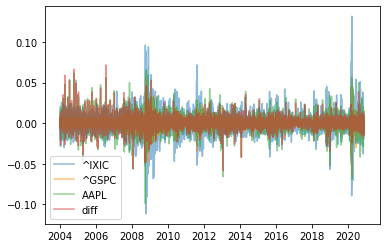

In [16]:
direction = -1
kw_port = {
    r'^IXIC':direction * 1.0, 
    r'^GSPC':direction * -0.5,
    r'AAPL':direction * -0.5
}

df = df_sims[kw_port].copy()
for ticker in kw_port:
    df[ticker] =  kw_port[ticker] * df[ticker]

df['diff'] = df.sum(axis=1)
df.plot(alpha = 0.5)

# VaR Calculations

##  exponentially weighted weighting function
Given $c$ and $d$, find 

$y = a * \exp(b x)$ with $0 < x < 1$

where
$\int_0^1 y dx = 1$ and $\int_{1-c}^1 y dx = d$

In [17]:
def weight_func(c, d):
        
    def b_eq(b):
        return (np.exp(b) - 1.0)/(np.exp(b) - np.exp(b*(1.0-d))) - 1.0/c
    b = sciop.newton(b_eq, 1.0)
    a = b / (np.exp(b)-1.0)
    return a, b

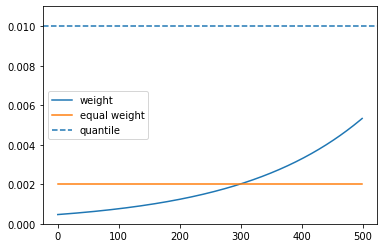

In [18]:
n_win = 500
target_percentile = 0.01
q = target_percentile

# setthing the weighting function
c, d = 0.5, 0.25
a, b = weight_func(0.5, 0.25)

v_ones = np.ones(n_win)
v_idx = 1.0*np.arange(0, n_win)/n_win

v_weights = a * np.exp(b*v_idx)
v_weights /= v_weights.sum() 
v_eq = v_ones/n_win

plt.figure()
plt.plot(v_weights, label='weight')
plt.plot(v_eq, label='equal weight')
plt.axhline(q, ls='--', label = 'quantile')
plt.ylim([0, 1.1*np.maximum(q,np.max(v_weights))])
plt.legend()

plt.show()

In [6]:
def weighted_quantile(v_x, v_w, q, info=None):
    
    # sort v_x
    v_i = np.argsort(v_x)
    v_x_s = v_x[v_i]
    v_w_s = v_w[v_i]
    v_wc = np.cumsum(v_w_s)
    
    x_q = np.interp(q, v_wc, v_x_s)
    info = {'x':v_x_s, 'w':v_wc}
    return x_q

def weighted_es(v_x, v_w, q, info=None):
    
    # sort v_x
    v_i = np.argsort(v_x)
    v_x_s = v_x[v_i]
    v_w_s = v_w[v_i]
    v_wc = np.cumsum(v_w_s)
    
    x_q = np.interp(q, v_wc, v_x_s)
    info = {'x':v_x_s, 'w':v_wc}
    return x_q



# test
v_x_test = np.arange(n_win, 0, -1)
var_eq = weighted_quantile(v_x_test, v_eq, q)
var_wq = weighted_quantile(v_x_test, v_weights, q)
var_d = weighted_quantile(v_x_test, v_weights, c)
print('equal: ' + str(var_eq))
print('weighted: ' + str(var_wq))
print('weighted for ' + str(c) + ': ' + str(var_d))

equal: 5.0
weighted: 1.8808869906390235
weighted for 0.5: 124.99999999999984


## Equally weighted and weighted

In [7]:
df['wq'] = df['diff'].rolling(window=n_win).apply(lambda x: weighted_quantile(x.values, v_weights, q))
df['eq'] = df['diff'].rolling(window=n_win).apply(lambda x: weighted_quantile(x.values, v_eq, q))
df['wq_eq'] = np.minimum(df['wq'], df['eq'])


## EWMA

In [8]:
df['ewm_vol'] = df['diff'].ewm(halflife=60).std()
df['eps'] = df['diff']/df['ewm_vol']
df['ew'] = df['eps'].rolling(window=n_win).apply(lambda x: weighted_quantile(x.values, v_eq, q))
df['ew'] = df['ew'] * df['ewm_vol']

# Exceptions

## preparations

In [9]:
# insert realised by shifting
df['realised'] = df['diff'].shift(-1)
kw_label = {'eq':'equal', 'wq':'weighted', 'ew':'ewma'}

## comparion of weighting schemems

In [10]:
def compare_fig(df, s1, s2, kw_label):
    
    l1 = kw_label[s1]
    l2 = kw_label[s2]
    x = df.index
    y = df['realised']
    e1 = df[s1] > y
    e2 = df[s2] > y
    e1_only = e1 & ~e2
    e2_only = e2 & ~e1
    e12 = e1 & e2

    ax1 = plt.subplot(211)
    plt.plot(x, y, c=[0.5, 0.5, 0.5], lw=0.5)
    p_s1 = plt.plot(x, df[s1], label='var_' + l1)
    p_s2 = plt.plot(x, df[s2], label='var_' + l2)
    c_s1 = p_s1[0].get_color()
    c_s2 = p_s2[0].get_color()
    
    # exceptions
    plt.plot(x[e12], y[e12], 'rx', label='common')
    plt.plot(x[e1_only], y[e1_only], 'o', c = c_s1, label=l1)
    plt.plot(x[e2_only], y[e2_only], 'o', c = c_s2, label=l2)
    plt.legend(loc='upper left')
    
    ax2 = plt.subplot(212, sharex=ax1)
    
    plt.axhline(4.33, c='g')
    plt.axhline(4.66, c='y')
    plt.axhline(9.33, c='y')
    plt.axhline(9.66, c='r')

    plt.plot(x, e1.rolling(250).sum(), ':', c = c_s1, label=l1)
    plt.plot(x, e2.rolling(250).sum(), '--', c = c_s2, label=l2)
    
    plt.legend(loc='upper left')

### Equally weighted vs exponentially weighted

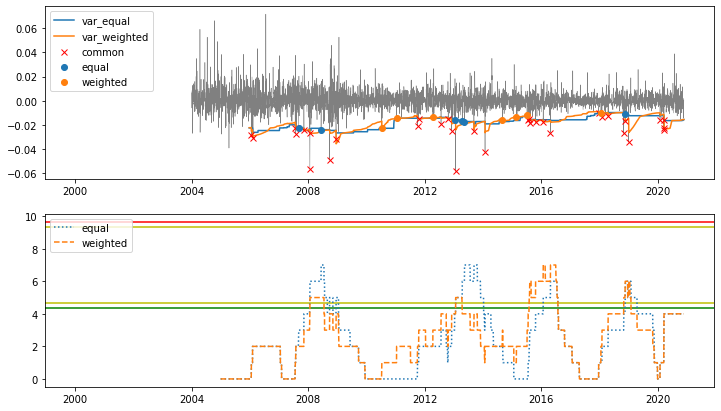

In [11]:
plt.figure(figsize=(12, 7))
compare_fig(df, 'eq', 'wq', kw_label)
plt.show()

### Equally weighted vs EWMA

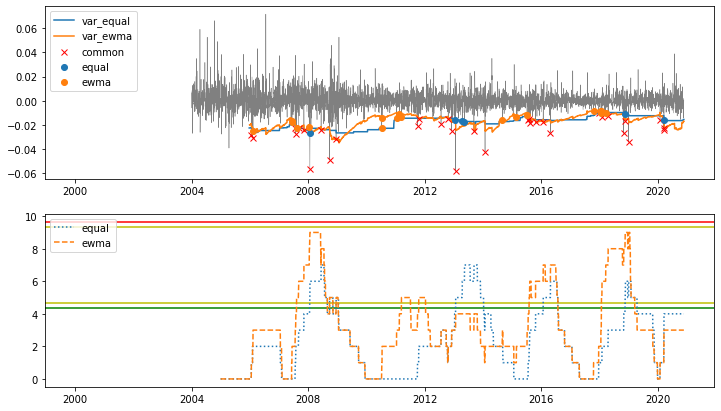

In [12]:
plt.figure(figsize=(12, 7))
compare_fig(df, 'eq', 'ew', kw_label)
plt.show()

### Exponentially weighted vs EWMA

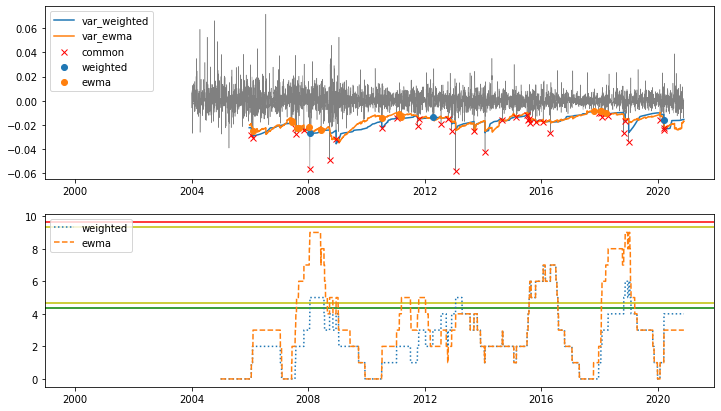

In [13]:
plt.figure(figsize=(12, 7))
compare_fig(df, 'wq', 'ew', kw_label)
plt.show()